In [0]:
!pip3 install transformers

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import torch
import torch.nn as nn
import transformers
import tqdm
from sklearn.model_selection import train_test_split
from transformers import BertModel,BertTokenizer

In [0]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train_data = train_data.drop(['id'],axis=1)
train_data.head()

,label,tweet
0,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,0,Finally a transparant silicon case ^^ Thanks t...
2,0,We love this! Would you go? #talk #makememorie...
3,0,I'm wired I know I'm George I was made that wa...
4,1,What amazing service! Apple won't even talk to...


In [0]:
print(train_data[train_data['label'] == 1].size)
print(train_data[train_data['label'] == 0].size)

4052
11788


Text(0, 0.5, 'Frequency')

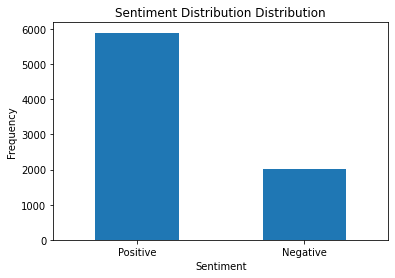

In [0]:
LABELS = ['Positive','Negative']
count_classes = pd.value_counts(train_data['label'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Sentiment Distribution Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Sentiment")

plt.ylabel("Frequency")

# pre processing

In [0]:
train_data['tweet'] = train_data['tweet'].apply((lambda x:re.sub("\#", " ",x.lower())))
train_data['tweet'] = train_data['tweet'].apply((lambda y:re.sub("http://\S+|https://\S+"," ", y)))

test_data['tweet'] = test_data['tweet'].apply((lambda x:re.sub("\#", " ",x.lower())))
test_data['tweet'] = test_data['tweet'].apply((lambda y:re.sub("http://\S+|https://\S+"," ", y)))


train_data['tweet'] = train_data['tweet'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
test_data['tweet'] = test_data['tweet'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [0]:
train_data['tweet'] = train_data['tweet'].apply((lambda x:re.sub("\^", " ",x.lower())))
test_data['tweet'] = test_data['tweet'].apply((lambda x:re.sub("\^", " ",x.lower())))


In [0]:
train_data.head()

,label,tweet
0,0,fingerprint pregnancy test android apps ...
1,0,finally a transparant silicon case thanks t...
2,0,we love this would you go talk makememories ...
3,0,im wired i know im george i was made that way ...
4,1,what amazing service apple wont even talk to m...


In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [0]:
class BERTBaseUncased(nn.Module):
    def __init__(self):
        super(BERTBaseUncased, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.bert_drop = nn.Dropout(0.3)
        self.out = nn.Linear(768, 1)
    
    def forward(self, ids, mask, token_type_ids):
        _, o2 = self.bert(
            ids, 
            attention_mask=mask,
            token_type_ids=token_type_ids
        )
        bo = self.bert_drop(o2)
        output = self.out(bo)
        return output

In [0]:
class sentimentDataset:

  def __init__(self,tweet,label,tokenizer,max_len):
    self.tweet = tweet
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len

    def __len__(self):
      return len(self.tweet)
    
    def __getitem__(self,item):
      tweet = str(self.tweet[item])
      label = self.label[item]


    encoding = self.tokenizer.encode_plus(tweet,None,add_special_tokens=True,max_length = self.max_len,pad_to_max_length=True)
    ids = encoding["input_ids"]
    mask = encoding["attention_mask"]
    token_type_ids = encoding["token_type_ids"]
    return {
        "ids":torch.tensor(ids,dtype=torch.long),
        "mask":torch.tensor(mask,dtype=torch.long),
        "token_type_ids":torch.tensor(token_type_ids,dtype=torch.long),
        "targets":torch.tensor(self.label[item],dtype=torch.float)
            }

In [0]:
def loss_fn(outputs, targets):
    return nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1))


def train_fn(data_loader, model, optimizer, device, scheduler):
    model.train()

    for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
        ids = d["ids"]
        token_type_ids = d["token_type_ids"]
        mask = d["mask"]
        targets = d["targets"]

        ids = ids.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(
            ids=ids,
            mask=mask,
            token_type_ids=token_type_ids
        )

        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()


def eval_fn(data_loader, model, device):
    model.eval()
    fin_targets = []
    fin_outputs = []
    with torch.no_grad():
        for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
            ids = d["ids"]
            token_type_ids = d["token_type_ids"]
            mask = d["mask"]
            targets = d["targets"]

            ids = ids.to(device, dtype=torch.long)
            token_type_ids = token_type_ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.float)

            outputs = model(
                ids=ids,
                mask=mask,
                token_type_ids=token_type_ids
            )
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [0]:
def run():
    dfx = pd.read_csv('train.csv').fillna("none")
    # dfx.sentiment = dfx.sentiment.apply(
    #     lambda x: 1 if x == "positive" else 0
    # )

    df_train, df_valid = train_test_split(
        dfx,
        test_size=0.1,
        random_state=42,
        stratify=dfx.labels.values
    )

    df_train = df_train.reset_index(drop=True)
    df_valid = df_valid.reset_index(drop=True)

    train_dataset = dataset.BERTDataset(
        review=df_train.review.values,
        target=df_train.sentiment.values
    )

    train_data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config.TRAIN_BATCH_SIZE,
        num_workers=4
    )

    valid_dataset = dataset.BERTDataset(
        review=df_valid.review.values,
        target=df_valid.sentiment.values
    )

    valid_data_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=config.VALID_BATCH_SIZE,
        num_workers=1
    )

    device = torch.device("cuda")
    model = BERTBaseUncased()
    model.to(device)
    
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
    ]

    num_train_steps = int(len(df_train) / config.TRAIN_BATCH_SIZE * config.EPOCHS)
    optimizer = AdamW(optimizer_parameters, lr=3e-5)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_train_steps
    )

    model = nn.DataParallel(model)

    best_accuracy = 0
    for epoch in range(config.EPOCHS):
        engine.train_fn(train_data_loader, model, optimizer, device, scheduler)
        outputs, targets = engine.eval_fn(valid_data_loader, model, device)
        outputs = np.array(outputs) >= 0.5
        accuracy = metrics.accuracy_score(targets, outputs)
        print(f"Accuracy Score = {accuracy}")
        if accuracy > best_accuracy:
            torch.save(model.state_dict(), config.MODEL_PATH)
            best_accuracy = accuracy

In [0]:
run()

In [1]:
!pip3 install sentencepiece

     |████████████████████████████████| 1.1MB 7.9MB/s 


In [0]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [0]:


import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

import tokenization



In [0]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [0]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model



In [0]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)


In [0]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

In [8]:
train.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


In [0]:


vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)


In [0]:
train_input = bert_encode(train.tweet.values, tokenizer, max_len=160)
test_input = bert_encode(test.tweet.values, tokenizer, max_len=160)
train_labels = train.label.values

In [11]:
model = build_model(bert_layer, max_len=160)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [12]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=3,
    callbacks=[checkpoint],
    batch_size=16
)



Epoch 1/3
396/396 [==============================] - 464s 1s/step - loss: 0.2379 - accuracy: 0.9009 - val_loss: 0.2019 - val_accuracy: 0.9186
Epoch 2/3
396/396 [==============================] - 387s 976ms/step - loss: 0.1397 - accuracy: 0.9468 - val_loss: 0.2421 - val_accuracy: 0.9053
Epoch 3/3
396/396 [==============================] - 387s 977ms/step - loss: 0.0593 - accuracy: 0.9801 - val_loss: 0.2346 - val_accuracy: 0.9167


In [0]:
model.load_weights('model.h5')
test_pred = model.predict(test_input)


In [0]:
submission['label'] = test_pred.round().astype(int)
submission.to_csv('new_submission.csv', index=False)
